In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC ,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">2º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº 49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>


# 1 – Introdução

Neste trabalho, vamos aplicar métodos supervisionados e não supervisionados através do dataset IMDB. Para isso, vamos também aplicar pré-processamento ao texto de modo a transformar os documentos em dados que ....

O objetivo principal do trabalho passa pela avaliação e comparação dos diferentes métodos aplicados, através de várias métricas de desempenho. Para esse efeito, são utilizadas métricas como matriz de confusão que permitem analisar e comparar o comportamento dos modelos ao longo dos testes que fizemos.

Durante o trabalho apresentamos as limitações identificadas, tanto ao nível do pré-processamento como das escolhas dos modelos utilizados. Referimos também algumas possíveis melhorias a considerar em trabalhos futuros e apresentamos as conclusões obtidas a partir dos resultados alcançados.

# 2 - Desenvolvimento


## 2.1 - Transformação de dados com TF-IDF

Antes da transformação dos textos com TF-IDF, aplicámos técnicas de pré-processamento com o objetivo de reduzir o numero de dado. Para isso aplicamos as seguintes regras:

- Remoção de tags HTML e caracteres não alfabéticos para tokens sem valor semântico.
- Aplicámos stemming para reduzir palavras de modo a reduzir o número de tokens.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from nltk.stem import  LancasterStemmer, PorterStemmer

# carregar dados
D = pickle.load(open("imdbFull.p", "rb"))
data = D["data"]
labels = D["target"]

#data = data[0:5000] # TODO: Remove this when pickling the final data
#labels = labels[0:5000]

def clean_text(t):
    t = t.replace("<br />", " ")                  
    t = re.sub(r"[^a-zA-Z]+", " ", t)             
    t = t.lower()
    return t

def apply_stemming(text, stemmer):
    return " ".join(stemmer.stem(word) for word in text.split())

def clean_dataset(data, stemmer):
    X_clean = []
    
    for t in data:
        cleaned = clean_text(t)
        cleaned = apply_stemming(cleaned, stemmer)
        X_clean.append(cleaned)
    
    return X_clean



Para obter a melhor configuração possível, testámos cada combinação de parâmetros em paralelo através de um classificador binário e avaliando o valor de _precision_ obtido. Esta métrica mede a proporção de previsões positivas que correspondem a casos realmente positivos, permitindo ajustar os parâmetros do TF-IDF de modo a obter uma representação mais adequada para a tarefa de classificação. Os parâmetros que avaliámos foram:

- `min_df`: Define o número mínimo de documentos em que uma palavra tem de aparecer para ser considerada. Serve sobretudo para ignorar palavras que aparecem pouco nos documentos.

- `max_df`: Define a frequência máxima com que uma palavra pode aparecer nos documentos. Serve para filtrar palavras que aparecem com muita frequência como "and", "is", "or" entre outras.

- `max_features`: Limita o número total de palavras usadas na representação TF-IDF. Isto ajuda a "controlar" o tamanho dos vetores, tornando o modelo mais rápido de treinar.

- `stop_words`: Indica se devem ser removidas palavras muito comuns. Estas palavras aparecem frequentemente, mas não acrescentam valor aos documentos.

- `token_pattern`: Define a regra usada para decidir o que conta como uma palavra válida. Neste caso, é usado para excluir palavras muito curtas, que normalmente não têm grande significado.

- `ngram_range`: Define se usamos apenas palavras isoladas ou também sequências de palavras. Ao incluir n-grams, o modelo consegue captar algumas expressões ou combinações de palavras que fazem mais sentido juntas do que separadas.

Outras coisas que testámos foi diferentes tipos de _stemmers_ e podiamos testar com multiplos classificadores. 

Depois de escolhermos os melhores parametros, fazemos a vectorização do texto e guardamos esse resultado para depois ser reutilizado nos classificadores seguintes

In [4]:
# transformar em 0 e 1
y_bin = np.where(labels < 5, 0, 1)

# dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    data, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

lancaster = LancasterStemmer()
porter = PorterStemmer()    

lr = LogisticRegression(max_iter=2000, random_state=42)

# parâmetros TF-IDF a testar
min_dfs = [3, 5] # min_dfs ->  used for removing terms that appear too infrequently
max_dfs = [0.5, 0.75] # max_df ->  used for removing terms that appear too frequently
max_features = [1000, 5000] # max_features ->  used for limiting the number of features
stop_words_list = [None, "english"] # stop_words_list ->  used for removing stop words
token_patterns = [r"[a-zA-Z]{3,}", r"[a-zA-Z]{4,}"]
ngrams = [(1,2)] # ngrams -> configures the n-grams
classifiers = [lr]
stemmers = [lancaster, porter] # stemmers ->  used for stemming the text

results = []
# ~15m
def run_combination(X_train, X_test, stemmer, min_df, max_df, sw, tp,ng,max_feature):
    print("Combo: ", stemmer, min_df,  sw, tp,ng,max_feature)
    X_train_clean = clean_dataset(X_train, stemmer) 
    X_test_clean = clean_dataset(X_test, stemmer)
    
    # criar TF-IDF para esta combinação
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        stop_words=sw,
        token_pattern=tp,
        ngram_range=ng,
        max_features=max_feature,
    )
    metrics = []
    
    # aplicar TF-IDF
    Xtr = vectorizer.fit_transform(X_train_clean)
    Xts = vectorizer.transform(X_test_clean)
    
    for classifier in classifiers:
        classifier.fit(Xtr, y_train)
        pred_lr = classifier.predict(Xts)
        metrics.append(precision_score(y_test, pred_lr))
    
    media = np.sum(metrics) / len(metrics)
    
    print(f"Stemmer={stemmer} | Média={media}") # ordenar por performance da SVM
    return vectorizer, stemmer, media

"""
# Sequencialmente
for stemmer in stemmers:
    for max_feature in max_features:
        for min_df in min_dfs:
            for sw in stop_words_list:
                for tp in token_patterns:
                    for ng in ngrams:
                        run_combination(X_train, X_test, stemmer, min_df, sw, tp, ng, max_feature)
"""

def parallel_tfidf(data, use_pickled=False):
    fname = "data_clean.pkl"
    
    if(use_pickled):
        vectorizer, cleaned_data = pickle.load(open(fname, 'rb'))
        return vectorizer, cleaned_data, 

    total = len(max_dfs) * len(min_dfs) * len(max_features) * len(stop_words_list) * len(token_patterns) * len(ngrams) * len(stemmers) * len(classifiers)
    print(f"Combinações: {total}")


    # Paralelo
    all_combinations = [
        (X_train, X_test,stemmer,min_df,max_df,sw,tp,ng,max_feature)
        for stemmer in stemmers
        for min_df in min_dfs
        for max_df in max_dfs
        for sw in stop_words_list
        for tp in token_patterns
        for ng in ngrams
        for max_feature in max_features
    ]
    
    # 2.4 minutos (96 * 2 combos)
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_combination)(*combo) for combo in all_combinations
    )

    sorted_results = sorted(results, key=lambda x: x[2], reverse=True)
    
    vectorizer, stemmer, media = sorted_results[0]
    cleaned_data = clean_dataset(data, stemmer)
    
    print("Final Combo", stemmer, vectorizer)
    
    file = open(fname, 'wb')
    pickle.dump((vectorizer,cleaned_data), file)
    return vectorizer, cleaned_data

vectorizer, cleaned_data = parallel_tfidf(data, use_pickled=True)
print(cleaned_data[0][:1000])
print(vectorizer)



zero day lead you to think even re think whi two boy young men would do what they did commit mutual suicid via slaughter their classmat it captur what must be beyond a bizarr mode of be for two human who have decid to withdraw from common civil in order to defin their own mutual world via coupl destruct it is not a perfect movi but given what money time the filmmak and actor had it is a remark product in term of explain the motiv and action of the two young suicid murder it is better than eleph in term of be a film that get under our rationalist skin it is a far far better film than almost anyth you are like to see flaw but honest with a terribl honesti
TfidfVectorizer(max_df=0.75, max_features=5000, min_df=5, ngram_range=(1, 2),
                token_pattern='[a-zA-Z]{3,}')


C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
def plot_CF(cm_1, cm_2, title_prefix1, title_prefix2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    
    # Mostra matriz de confusão 1, com o titlo desejado, title_prefix1
    disp_train = ConfusionMatrixDisplay(cm_1)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')
    
    # Mostra matriz de confusão 2, com o titlo desejado, title_prefix2
    disp_test = ConfusionMatrixDisplay(cm_2)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    plt.tight_layout()
    plt.show()

def plot_multi_classe(cm_1, cm_2, modelo1, modelo2, title_prefix1, title_prefix2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    
    cm_display1=ConfusionMatrixDisplay(cm_1, display_labels=modelo1.classes_)
    cm_display1.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix1}')

    cm_display2=ConfusionMatrixDisplay(cm_2, display_labels=modelo2.classes_)
    cm_display2.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix2}')
    
    plt.tight_layout()
    plt.show()

## 2.2 - Treino de Classificadores

- train/test split com estratificação,
- k-fold cross validation, StratifiedKFold,

- análise de métricas: matriz de confusão, recall, precision.


In [43]:
# regressor linear com test train split e idf
# exemplo feito durante a aula só para referencia para a malta. Usar o vectorizer de cima
"""
X_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)

# transform train e test
X_train_idf = vectorizer.transform(X_train)
X_test_idf = vectorizer.transform(X_test)

# regressor linear
lr = LogisticRegression(max_iter=1000)

# fit
lr.fit(X_train_idf, y_train)

# predict
lr.predict(X_test_idf)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)\n\n# transform train e test\nX_train_idf = vectorizer.transform(X_train)\nX_test_idf = vectorizer.transform(X_test)\n\n# regressor linear\nlr = LogisticRegression(max_iter=1000)\n\n# fit\nlr.fit(X_train_idf, y_train)\n\n# predict\nlr.predict(X_test_idf)\n'

In [5]:
vectorizer, data = pickle.load(open('../TP2/data_clean.pkl','rb'))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/3, random_state=42)

# Transformar os dados de treino e teste usando o vectorizer obtido
X_train_idf = vectorizer.transform(X_train)
X_test_idf = vectorizer.transform(X_test)

c:\Users\bigui\miniconda3\envs\env-AA\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\bigui\miniconda3\envs\env-AA\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 2.2.1 - Classificação multi-classe

Treinar um modelo que recebe o texto da crítica e prevê a pontuação exata (1–4 ou 7–10 → total de 8 classes).

- Escolhes um ou mais modelos adequados (com base nos slides):
- Exemplos de classificadores
- Logistic Regression,
- SVM,
- Linear Regression,
- Lasso Regression

Depois:

- comparar classificadores e regressões,
- converter previsões da regressão em classes,
- analisar qual abordagem funciona melhor.


Como foi referido na introdução, neste trabalho vai ser utilizada a classificação multi-classe para classificar as diferentes críticas presentes no dataset imdbFull.

A multi-classe é geralmente utilizado quando existem três ou mais classes possíveis e cada exemplo de dados pertencem a exatamente uma dessas classes. No nosso caso, o dataset é composto por 50 mil críticas e as respetivas notas, nos intervalos [1-4] e [7-10].


#### **Distribuição das avaliações, para o conjunto de teste**


Primeiro, iremos verificar quantas labels (avaliações) existem no conjunto de teste. Para tal, foi criado um gráfico de barras que apresenta a quantidade de críticas para cada avaliação (nota da crítica).


Distribuição das Notas (Labels):
------------------------------
Nota 1: 3322 críticas
Nota 2: 1533 críticas
Nota 3: 1664 críticas
Nota 4: 1770 críticas
Nota 7: 1631 críticas
Nota 8: 1969 críticas
Nota 9: 1506 críticas
Nota 10: 3272 críticas
------------------------------
Total: 16667 críticas


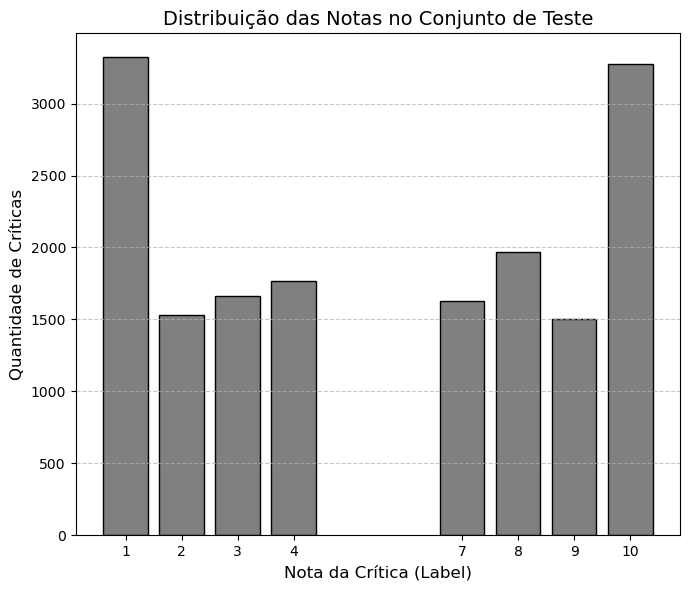

In [6]:
import matplotlib.pyplot as plt

contagem = {}

for nota in y_test:
    contagem[nota] = contagem.get(nota, 0) + 1

# 3. Mostrar os resultados de forma organizada
print("Distribuição das Notas (Labels):")
print("-" * 30)
total = 0
for nota in sorted(contagem.keys()):
    print(f"Nota {nota}: {contagem[nota]} críticas")
    total += contagem[nota]

print("-" * 30)
print(f"Total: {total} críticas")

# 1. Preparar os dados (garantindo a ordem das notas de 1 a 10)
notas_ordenadas = sorted(contagem.keys())
valores = [contagem[nota] for nota in notas_ordenadas]

# 2. Criar a figura
plt.figure(figsize=(7, 6))

# 3. Criar o gráfico de barras
bars = plt.bar(notas_ordenadas, valores, color='gray', edgecolor='black')

# 4. Adicionar os números exatos em cima de cada barra
for bar in bars:
    yval = bar.get_height()

plt.title('Distribuição das Notas no Conjunto de Teste', fontsize=14)
plt.xlabel('Nota da Crítica (Label)', fontsize=12)
plt.ylabel('Quantidade de Críticas', fontsize=12)
plt.xticks(notas_ordenadas)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Como é possível observar, através do gráfico, o número de críticas com notas 1 e 10 (extremos) é maior, e em alguns casos o dobro, que as restantes avaliações.

Um dos possíveis motivos para isto acontecer pode estar relacionado com o tipo de avaliação que é realizado pelos utilizadores, uma vez que as avaliações mais comuns, em qualquer dataset de avalização, são as extremidades, nota 1 e 10. Nota: Talvez seja por este motivo que o dataset imdbFull não apresenta avaliações com notas 5 e 6.


#### **Gráfico de dispersão das classes (avaliações)**


Antes ainda de avançarmos para a multi-classe, vamos construir um gráfico que nos ajuda a determinar se a classificação vai ter um bom desempenho em separar as diversas classes.

Para tal, como queremos construir um gráfico 2d (plano bidimensional) temos de transformar o conjunto de dados de 8 dimensões, para apenas 2. A maneira mais fácil de realizar este processo é com a utilização do PCA (Principal Component Analysis), que agrupa as colunas criadas pelo TF-IDF em apenas duas colunas principais, tentando manter o máximo de informação possível (processo necessário para colocar dados no plano bidimensional).

Com os dados transformados, foi criada uma função para criar o gráfico com os primeiros dados de treino e teste conforme as duas colunas principais obtidas durante o processo de PCA. Como só queremos ter uma ideai geral do dataset e para facilitar a interpretação do gráfico, vão ser selecionados apenas os primeiros 5000.


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42) # PCA para 2D

X_train_2d = pca.fit_transform(X_train_idf.toarray())
X_test_2d = pca.transform(X_test_idf.toarray())

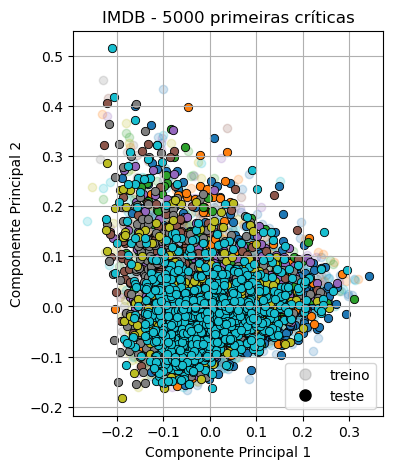

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def grafico_imdb_pca(X_train_2d, X_test_2d, y_train, y_test):
    classes = sorted(set(y_train))
    cores = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(4, 5))

    # TREINO
    for c, cor in zip(classes, cores):
        idx = (y_train == c)
        plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], color=cor, alpha=0.2)

    # TESTE 
    for c, cor in zip(classes, cores):
        idx = (y_test == c)
        plt.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], color=cor, edgecolors="black", linewidths=0.6)

    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title("IMDB - 5000 primeiras críticas")
    plt.grid(True)

    # Legenda
    legend_elements = [
        Line2D([0], [0],marker='o',color='gray',label='treino',markerfacecolor='gray',markersize=8,alpha=0.3,linestyle='None'),
        Line2D([0], [0],marker='o',color='black',label='teste',markerfacecolor='black',markeredgewidth=1,markersize=8,linestyle='None')
    ]

    plt.legend(handles=legend_elements, loc="best")
    plt.legend(handles=legend_elements, loc="lower right")
    plt.show()

numero_criticas = 5000
grafico_imdb_pca(X_train_2d[:numero_criticas], X_test_2d[:numero_criticas], y_train[:numero_criticas], y_test[:numero_criticas])


Ao observar o gráfico, é possível verificar que o conjunto de críticas apresenta um conjunto de pontos misturados o que pode indicar os classificadores poderão ter alguma dificuldade em dividir as diversas classes.


#### **Logistic Regression**


O Logistic Regression é um classificador binário, no entanto pode ser adaptado para funcionar em problemas com 3 ou mais classes, como é o nosso caso.

Em termos de multi-classe, este modelo permite atribuir probabilidades a cada uma das classes possíveis, ou seja, em vez de simplesmente atribuir uma nota a cada crítica, ele calcula a probabilidade da mesma pertencer às diversas classes, escolhendo, no fim a que tem a maior probabilidade. Usa, por default, uma abordagem **multinomial** (não é preciso definir este parâmetro durante a GridSearch) que calcula um *score* com base nas palavras encontradas. Esses *scores* são depois processados por uma função matemática, própria do modelo, que transforma esse valor em probabilidades. De um modo geral esta abordagem **multinomial** treina apenas um único modelo que olha para todas as classes ao mesmo tempo (favorável a datasets onde é preciso classificar texto).

Para encontrar os melhores hiper-parametros é necessário repetir o processo realizado no TP1, através da utilização de uma **GridSearch**. Com hiper-parametros necessários divididos em *Regularização* e *Otimização*:

- *penalty*: Indica qual é a norma da penalidade a ser usada e serve principalmente para controlar o **overfitting**. As penalidades mais usada são:
- - *L2*: De nome, **Ridge**, ajuda a reduzir a magnitude dos coeficientes;
- - *L1*: De nome, **Lasso**, coloca a 0 os coeficiente das classes menos importantes;
- - *elasticnet**: Combina as duas penalidade de cima. De realçar que, para teste, é necessário definir também o parametros **l1_ratio**;

- *C*: Ao contrário da penalidade, quanto menor for o valor de *C* mais simples fica o modelo, por outro lado, quanto maior for o valor mais o modelo tenta se ajustar aos dados de treino;
- *solver*: Vai definir qual é o algoritmo utilizado para a multi-classe (lbjgs, newton-cg e saga). A escolha deste parâmetro depende da penalidade escolhida e do tamanho do dataset (50k para o nosso caso).

De um modo geral o processo é bastante idêntico ao realizado no TP1, onde utilizámos a gridSearch para encontrar os melhores hiper-parametros e fizemos o *predict* com os valores de teste. No entanto, a gridSearch para a multi-classe vai ser um pouco diferente visto que existem limitações das combinações entre hiper-parametros, como por exemplo o solver **lbfgs** não poder utilizar a penalidade **l1** ou então a possibilidade do solver **saga** utilizar a penalidade **elasticnet**.

De salientar ainda a importancia do parametro *class_weight* com valor **balanced**. Este parametro é extremamente importante quando a distribuição das labels não é uniforme, como o nosso caso (observado anteriormente, com o gráfico de barras), uma vez que, sem ele, o modelo classifica mais vezes as classes predominantes. Para contrariar esse fenómeno, este parâmetro aplica um peso consoante o numero de críticas por classe (notas com menor quantidade vão ter um peso maior) o que ajuda a regular a classificação.

Neste caso, o **param_grid** foi composto por 3 conjuntos que abrangeram todas as combinações principais possíveis.

Em relação ao GridSearch, foi utilizado o scoring **f1_weight** que decide qual é a melhor combinação de hiper-parametros a se usar. Tanto o **f1_weight** quanto o **balanced** são extremamente importantes para o nosso obejtivo de classificar um dataset de texto e sem um deles, o modelo vai ter dificuldades a classificar as notas intermédias (o class_weight ajuda o modelo a obter uma melhor classificação e o f1_weight garante que o GridSearch escolhe o modelo, e os hiper-parametros, que melhor equilibram todas as classes).


No fim, foi calculado o *score*, o *classification report* e foi apresentada a matriz de confusão.



Classificador treinado com Grid Search CV.
Melhores parâmetros: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Melhor estimador: LogisticRegression(C=1, class_weight='balanced', random_state=42,
                   solver='newton-cg')
Score do Teste: 0.38303233935321296
              precision    recall  f1-score   support

           1       0.65      0.58      0.61      3322
           2       0.23      0.26      0.24      1533
           3       0.24      0.25      0.25      1664
           4       0.31      0.33      0.32      1770
           7       0.28      0.33      0.31      1631
           8       0.27      0.25      0.26      1969
           9       0.19      0.22      0.20      1506
          10       0.58      0.52      0.55      3272

    accuracy                           0.38     16667
   macro avg       0.34      0.34      0.34     16667
weighted avg       0.40      0.38      0.39     16667

Confusion Matrix:
 [[1931  622  371  212   39   3

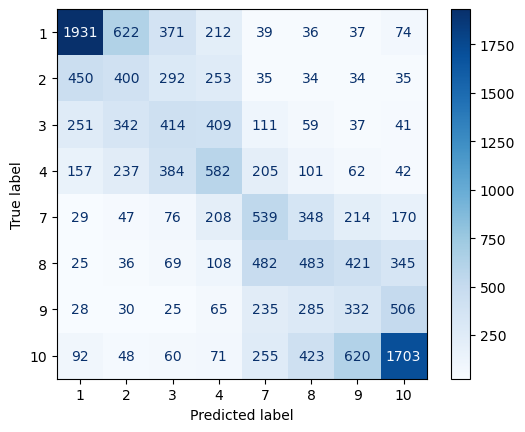

In [13]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score


clr = LogisticRegression(random_state=42)

param_grid_clr = [
    {
        # Primeiro Conjunto
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0.3, 0.5, 0.7],
        'C': [0.1, 1, 10,100]
    },
    {
        # Segundo Conjunto: 
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10,100],    
        'class_weight': ['balanced'] 
    },
    {
        # Terceiro Conjunto:
        'solver': ['lbfgs', 'newton-cg'],
        'penalty': ['l2'],
        'C': [0.1, 1, 10, 100],        
        'class_weight': ['balanced']
    } 
]

grid_search_clr = GridSearchCV(
    estimator=clr, 
    param_grid=param_grid_clr, 
    scoring='f1_weighted', 
    cv=5, 
    n_jobs=-1
)

grid_search_clr.fit(X_train_idf, y_train)

print("Classificador treinado com Grid Search CV.")
print("Melhores parâmetros:", grid_search_clr.best_params_)
print("Melhor estimador:", grid_search_clr.best_estimator_)

y_previsao_clr = grid_search_clr.best_estimator_.predict(X_test_idf)
score_clr = grid_search_clr.best_estimator_.score(X_test_idf, y_test)
print("Score do Teste:", score_clr)

print(classification_report(y_test, y_previsao_clr))

matrizC_clr = confusion_matrix(y_test, y_previsao_clr)
print("Confusion Matrix:\n", matrizC_clr)
fh_clr=ConfusionMatrixDisplay(matrizC_clr, display_labels=grid_search_clr.best_estimator_.classes_)
fh_clr.plot(cmap=plt.cm.Blues)

Com o modelo treinado e com as previsões feitas, avançamos para a análise dos resultados. 

Cmo é possível observar, o modelo estimado escolheu o *solver* newton-cg que é o indicado para lidar com um conjunto significativo de classes (8) e que consegue encontrar o valor mínimo de perda durante a classificação. Em relação ao valor da regularização, *C* e *penalty*, os valores escolhidos foram 1 e l2, respetivamente, indicando assim que o modelo manteve um equilíbrio entre ajustar os dados de treino, ao manter os pesos does coeficientes, e consegui assumir, através da penalidade igual a l2, que quase todas as palavras da crítica têm impacto na nota final.

Em termos de resultados numéricos, conseguimos observar um *score* de 0.383, 38,3%, que indica que este modelo linear pode não ser o mais indicado para o dataset imdbFull. Se analisarmos o resultado do *classification_report* é possível visualizar onde está o centro do problema. 

Através da **precisão**, existe uma maior desempenho nas notas dos extremos (1 e 10), com 65% e 58% respetivamente, o que indica que o modelo acerta bastantes vezes quando classifica uma crítica a pertencer a uma destas duas notas. Por outro lado, as notas 2, 3 e 9 têm as piores precisões, sobretudo a nota 9, o que pode realçar que o modelo, engana-se a classificar notas adjacentes, nomeadamente 8 e 10.
Ao olharmos para o **recall**, o modelo consegue identificar mais de metade das notas 1 e 10 (58% e 52%), por serem mais fáceis de classificar, ao invés das notas intermédias, onde os valores rondam os 22% e os 33%.
Por fim, através do **f1-score**, métrica que combina a precisão e o recall, é possível realçar que o modelo aprendeu bem os padrões das notas 1 e 10, muito mau ou muito bom, mas tem algumas dificuldades em distinguir diferenças subtis entre notas intermédias adjacentes, como é o caso das notas 2-3 e 8-9, com uma f1-score em volta dos 20% e dos 26%.

De salientar que a utilização do *balanced* tem um impcato bastante evidente neste tipo de modelos, uma vez que sem ele o score seria maior, por volta dos 43%, o que indicava um interesse exclusivo na classificação das notas 1 e 10 (maior quantidade) e afaastava-se da classificação das restantes notas (menor quantidde). 


#### **SVC**


O LinearSVC, é um dos algoritmos mais eficazes para a classificação de texto em geral e um implementação específica do SVM (Support Vector Machine), capaz de lidar com conjuntos de dados e classes elevado. A sua função principal é encontrar a fronteira (hiperplano) que maximize a distnânca entre as classes, ao contrário dos outros tipos de classificadores que apenas tentam separar as classes.

Este classificador, tal como o anterior, é binário, no entanto, para problemas de multi-classe, usa uma estratégia chamada One-vs-Rest (ovr). Nesta estratégia, o modelo treina um classificador independente para cada classe (nota da crítica), dividindo assim em subproblemas onde compara uma nota, por exemplo a nota 2, com todas as outras. Resumidamente, quando lhe é dado uma crítica, todos os 8 modelos (correspondem às 8 notas) dão uma pontuação baseada na distância do texto em relação à margem de decisão. No final, a que tiver maior pontuação é a escolhida para a previsão.

Ao contrário do Logistic Regression, vamos ter de encontrar um conjunto diferente de hiper-parametros. Para tal, são adicionados dois hiper-parametros que não foram referidos anteriormente:

- *loss*: Representa a função de perda, mede o "erro" do modelo e indica como se deve ajustar, durante o treino. De um modo geral, penaliza os pontos que estão do lado errado da fronteira de decisão e é utilizado pelo modelo para se focar apenas nos "pontos" que estão perto das fronteiras de decisão e não os que já estão corretamente classificados, normalmente perto do centroid.
- *dual*: Representa a forma como o modelo matemático é resolvido. Quando o seu valor é igual a **True**, o modelo/algoritmo foca-se na relação entre as críticas (exemplos de treino), ao tentar encontrar o valor de importância de cada crítica para conseguir definir as fronteiras. Se for **False**, tenta encontrar diretamente os pesos para cada palavra, presente nas respetivas críticas. De um modo geral, torna o modelo mais eficiente durante o treino.

Para além destes dois hiper-parametros, vão ser também utilizados a **penalidade**, o **C** e o **class_weight**. Neste caso, **param_grid** foi também composto por 3 conjuntos que abrangeram todas as combinações principais possíveis. Em contraste com o anterior, uma vez que este classificador necessita de mais tempo de processamento (por utilizar vetores), vai ser utilizado o RandomSearchCV com 8 combinações.

Por fim, calcula-se o *score*, o *classification report* e fé mostrada a matriz de confusão.


Classificador treinado com Randomized Search CV.
Melhores parâmetros: {'penalty': 'l2', 'loss': 'squared_hinge', 'dual': True, 'class_weight': 'balanced', 'C': 0.1}
Melhor estimador: LinearSVC(C=0.1, class_weight='balanced', dual=True, random_state=42)
Score do Teste: 0.4082318353632927
              precision    recall  f1-score   support

           1       0.60      0.72      0.66      3322
           2       0.23      0.17      0.19      1533
           3       0.26      0.20      0.23      1664
           4       0.32      0.33      0.32      1770
           7       0.29      0.32      0.30      1631
           8       0.27      0.20      0.23      1969
           9       0.18      0.14      0.16      1506
          10       0.53      0.64      0.58      3272

    accuracy                           0.41     16667
   macro avg       0.33      0.34      0.33     16667
weighted avg       0.38      0.41      0.39     16667

Confusion Matrix:
 [[2399  295  241  187   41   35   21  103]

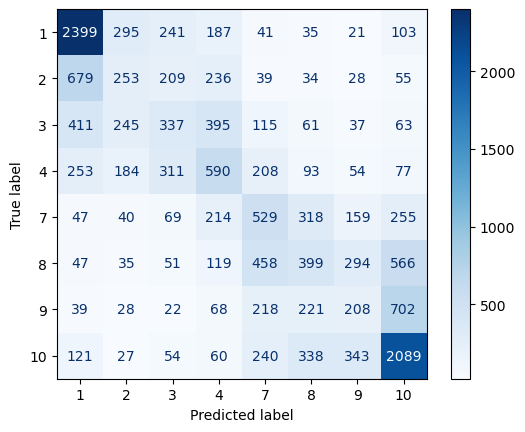

In [14]:
svc = LinearSVC(random_state=42)

param_grid_svc = [
    {
        # Primeiro Conjunto
        'penalty': ['l2'],
        'loss': ['squared_hinge'],
        'C': [0.1, 1, 10, 100],
        'dual': [True, False],
        'class_weight': ['balanced'],
    },
    {
        # Segundo Conjunto
        'penalty': ['l2'],
        'loss': ['hinge'],
        'C': [0.1, 1, 10, 100],
        'dual': [True],
        'class_weight': ['balanced'],
    },
    {
        # Terceiro Conjunto
        'penalty': ['l1'],
        'loss': ['squared_hinge'],
        'C': [0.1, 1, 10, 100],
        'dual': [False],
        'class_weight': ['balanced'],
    }
]

# Randomized Search CV dos parâmetros do SVC
random_search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid_svc,
    n_iter=8,           
    scoring='f1_weighted',
    cv=5,               
    n_jobs=-1,          
)

random_search_svc.fit(X_train_idf, y_train)

print("Classificador treinado com Randomized Search CV.")
print("Melhores parâmetros:", random_search_svc.best_params_)
print("Melhor estimador:", random_search_svc.best_estimator_)

y_previsao_svc = random_search_svc.best_estimator_.predict(X_test_idf)
score_svc = random_search_svc.best_estimator_.score(X_test_idf, y_test)
print("Score do Teste:", score_svc)

print(classification_report(y_test, y_previsao_svc))

matrixC_svc = confusion_matrix(y_test, y_previsao_svc)
print("Confusion Matrix:\n", matrixC_svc)
fh_svc=ConfusionMatrixDisplay(matrixC_svc, display_labels=random_search_svc.best_estimator_.classes_)
fh_svc.plot(cmap=plt.cm.Blues)

Vamos então analisar os resultados do LinearSVC.

Em relação aos parametros escolhidos, tal como no Logistic Regression foi escolhida uma penalidade de l2, no entanto o valor do *C* variou de 1 para 0,1. Isto indica que o modelo tentou encontrar um limte de deicasão mais simples, em vez de tentar classficiar perfeitamente cada crítica individualmente. Sobre os dois novos hiper-parametros que foram estabelecidos para o LinearSVC, o *loss* igual a **squared_hinge** indica que o modelo tentou penalizar as classificações que estavam muito longe do limite de decisão (o que ajuda a separar entre críticas negativas e positivas) e o *dual* igual a **True** foi escolhido com baase no numero de texto em cada crítica e as respetivas avaliações.

Ao olharmos para o score do modelo, apresenta um valor de 41%, razoável para este tipo de dataset. Em termos de *f1-score*, as notas dos extremos apresentam um valor bem maior que as restantes, 66% e 58% respetivamente, o que indica que o modelo consegui aprender melhor as críticas com palavras mais pesadas (quer em termos positivos quer em negativos). Por outro lado, para as notas intermédias, os valores são quase de 1/3 comparativamente às notas 1 e 10, o que indica uma dificuldade em distingui a intensidade em críticas com avaliações muito parecidas.

Por fim, podemos ainda olhar para o valor do *weighted avg* e do *macro avg*, onde a média ponderada, 41% é superior à média simples, 34% (em termos de recall), o que confirma que o modelo é mais competente nas classes com mais volume de críticas, extremos.

#### **Comparação entre os dois classificadores multi-classe**


Score do Logistic Regression:  0.38303233935321296
Score do SVC:                  0.4082318353632927


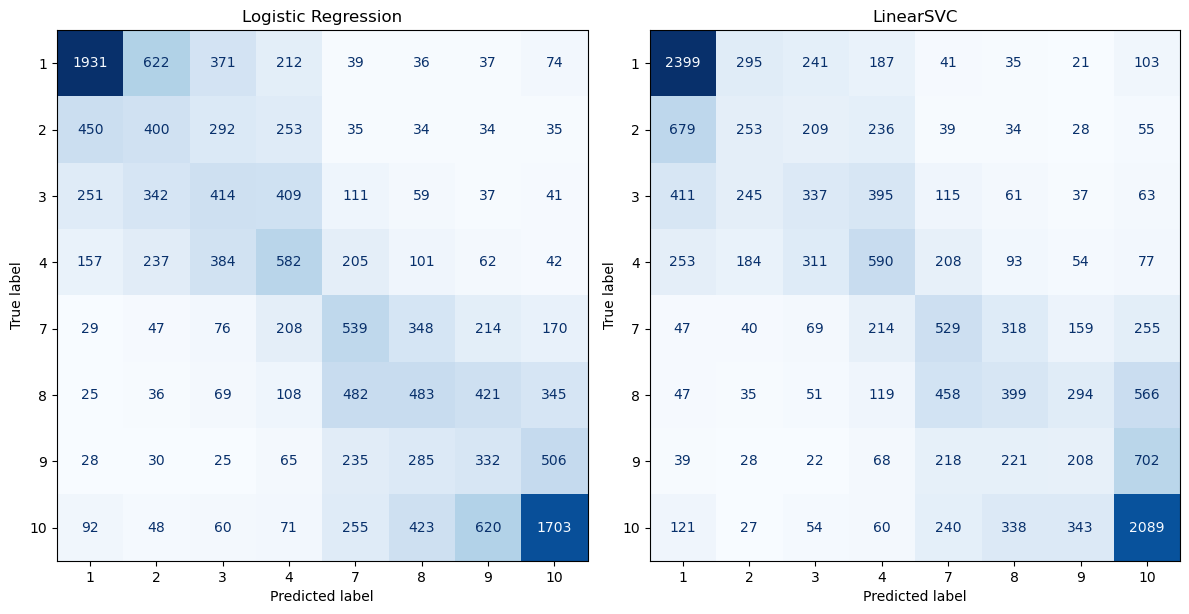

In [15]:
print("Score do Logistic Regression: ", score_clr)
print("Score do SVC:                 ", score_svc)

plot_multi_classe(matrizC_clr, matrixC_svc,grid_search_clr, random_search_svc, "Logistic Regression", "LinearSVC")

### 2.2.2 - Análise com Regressão Linear

Treinar um modelo para prever a pontuação contínua da crítica. Depois, converter as previsões contínuas do regressor para rótulos de classificação:

valores preditos → mapeados para 1–4 e 7–10.

Aqui, utilizaremos dois algoritmos de regressão da biblioteca sklearn para analisar o dataset IMDB, o LinearRegression e o LinearSVR.

O LinearRegression (Regressão Linear) consiste na tentativa de modelar a relação entre as palavras de cada crítica e a nota atríbuida, numa linha reta ou hiperplano. O modelo aprende um peso para cada palavra, aprendendo a diferenciar palavras em positivas como "excelente" e negativas como "horrível", atribuindo-lhe pesos positivos ou negativos, respetivamente. O objetivo principal deste algoritmo é encontrar a linha que minimiza a soma dos erros quadráticos, ou seja a distância entre as previsões e as notas reais. 

A LinearSVR é a versão de regressão das Support Vector Machines (SVMs). Enquanto a regressão linear tenta minimizar o erro de todos os pontos, o SVR tenta encaixar o maior número de pontos dentro e uma margem de tolerância. Se uma previsão estiver dentro desta margem, o algoritmo considera-o como sem erro, penalizando apenas pontos que estejam fora da margem de tolerância. Este comportamento torna-o mais robusto a outliers.
Ao contrário do LinearRegression, o SVR requere algum fine-tune para funcionar melhor, tendo como parâmetros:
- C, controla a rigidez do modelo. Um C mais baixo permite mais erros, enquanto um C mais alto tenta ajustar-se a todos os pontos, correndo o risco de overfitting.
- epsilon, define a largura da margem de tolerância. Como exemplo, se o epsilon estiver definido como 0.2 e a nota real for 8.0, se o modelo previr um valor 8.15, não existirá erro. Porém, se o modelo previsse o valor 8.25, já existiria erro.
- loss, define como penalizar os erros fora da margem de tolerância.

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

reg_model = LinearRegression()
reg_model.fit(X_train_idf, y_train)

y_pred = reg_model.predict(X_test_idf)

y_pred_clipped = np.clip(y_pred, 1, 10)

mae = mean_absolute_error(y_test, y_pred_clipped)
mse = mean_squared_error(y_test, y_pred_clipped)
r2 = r2_score(y_test, y_pred_clipped)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(confusion_matrix(y_test, np.round(y_pred_clipped).astype(int)))

Mean Absolute Error: 1.65
Mean Squared Error: 4.55
R^2 Score: 0.62
[[1014  670  639  503  275  137   61   14    8    1]
 [ 277  270  324  296  212   97   40   13    2    2]
 [ 200  231  307  344  301  185   66   14   11    5]
 [ 109  170  295  382  364  228  158   48   14    2]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    9   28   96  201  343  363  310  171  110]
 [   2    4   18   40  167  285  432  461  308  252]
 [   0    1    7   31   98  203  296  349  258  263]
 [   3    2   23   70  150  372  586  694  682  690]]


In [74]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
import numpy as np

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.0, 0.1, 0.2, 0.5],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

grid_search = GridSearchCV(
    LinearSVR(random_state=42, max_iter=10000), # Base
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1 
)

grid_search.fit(X_train_idf, y_train)
best_svr = grid_search.best_estimator_

print(f"\nBest Parameters found: {grid_search.best_params_}")

y_pred_svr_raw = best_svr.predict(X_test_idf)

y_pred_svr_clipped = np.clip(y_pred_svr_raw, 1, 10)

mae_svr = mean_absolute_error(y_test, y_pred_svr_clipped)
mse_svr = mean_squared_error(y_test, y_pred_svr_clipped)
r2 = r2_score(y_test, y_pred_svr_clipped)

print("SVR Regression Performance:")
print(f"MAE: {mae_svr:.4f}")
print(f"MSE: {mse_svr:.4f}")
print(f"R^2 Score: {r2:.4f}")

accuracy_svr = accuracy_score(y_test, y_pred_svr_clipped.round().astype(int))
print(f"Derived Classification Accuracy (SVR): {accuracy_svr:.2%}")
print(confusion_matrix(y_test, y_pred_svr_clipped.round().astype(int)))

/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/Desktop/isel/aa/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/Desktop/isel/aa/.v


Best Parameters found: {'C': 1, 'epsilon': 0.5, 'loss': 'epsilon_insensitive'}
SVR Regression Performance:
MAE: 1.6114
MSE: 4.3077
R^2 Score: 0.6430
Derived Classification Accuracy (SVR): 22.59%
[[927 698 676 545 280 126  50  14   3   3]
 [245 273 333 331 207 101  28  10   3   2]
 [162 220 327 360 352 158  57  16   9   3]
 [ 79 148 292 413 393 259 138  41   7   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  3   3  13 104 195 348 413 309 175  68]
 [  1   2  16  33 146 315 440 499 314 203]
 [  0   1   4  26  82 210 325 344 289 225]
 [  3   2  15  50 146 352 620 768 692 624]]


### Comparação entre LinearRegression e LinearSVR

Accuracy Linear Regression:  0.2246955060898782
Accuracy Linear SVR:         0.2258954820903582


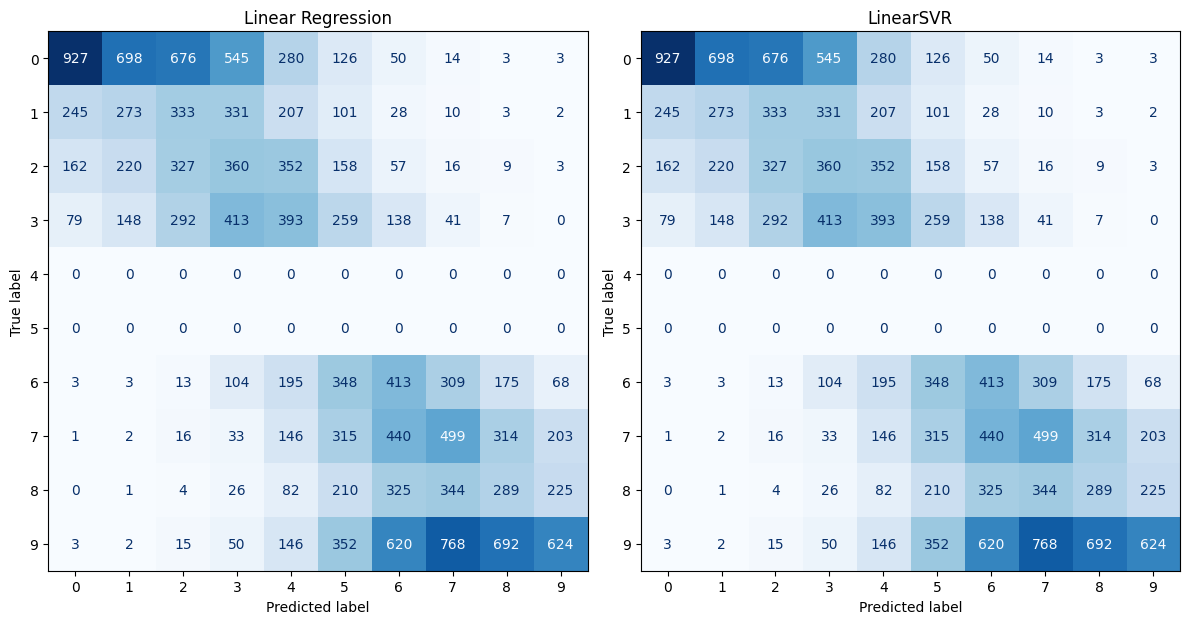

In [73]:
print("Accuracy Linear Regression: ", accuracy_score(y_test, np.round(y_pred_clipped).astype(int)))
print("Accuracy Linear SVR:        ", accuracy_svr)

matrixC_lnr = confusion_matrix(y_test, y_pred_svr_clipped.round().astype(int))
matrixC_lsvr = confusion_matrix(y_test, y_pred_svr_clipped.round().astype(int))

plot_CF(matrixC_lnr, matrixC_lsvr, "Linear Regression", "LinearSVR")

Analisando a performance geral entre o LinearRegression e o LinearSVR, é possível verificar que o LinearSVR apresenta uma taxa média absoluta de erro inferior ao LinearRegression e apresenta também um R² superior, logo podemos assumir uma performance ligeiramente superior deste modelo.

Analisando com mais detalhe os valores, um MAE de 1.6 indica que, em média, cada modelo erra a nota predita por cerca de 1.6 estrelas. Tendo em conta também o accuracy score, 22.59% é um valor bastante baixo, porém, conseguimos observar através da matriz de confusão que, mesmo não acertando com precisão na nota, acerta geralmente na sua vizinhança.

Esta falta de accuracy é expectável e um dos motivos pelos quais isto acontece é, por exemplo, um caso em que o modelo prevê algo como 9.2 que é arrendondado para 9, porém a classe verdadeira é 10. O erro é pequeno porém prejudica a acurácia. 

### 2.2.3 - Análise dos resultados

- desempenho da classificação direta,
- desempenho da classificação derivada da regressão.
  Para regressão, medir:
- MAE
- MSE


## 2.3 - Clustering


Para a parte do clustering, vamos aplicar métodos de clustering diferentes e comparar os resultados. Os métodos que vamos aplicar são:

- KMeans
- AgglomerativeClustering (clustering hierárquico)

Vamos ainda aplicar PCA para reduzir o numero de dimensões do nosso dataset e ver se isso melhora o desempenho dos nossos métodos de clustering
Para termos uma base de comparação, vamos apenas usar 10 clusters para todos os métodos, e depois vamos avaliar o parametro k e perceber o impacto deste parametro.

Para avaliar o desempenho, vamos utilizar duas métricas retornadas pelas funções: silhouete e inertia. A inertia é uma métrica que mede a distancia dos pontos aos seus clusters atribuidos. Quanto menor for esse valor, mais pertos os pontos estão do seu cluster. Este valor é sensivel ao parametro K, porque ao diminuir o numero de clusters, estamos a colocar mais pontos por cluster, logo a aumentar a _inertia_.

A silhouette é uma métrica que mede se os pontos estão mais próximos ao seu cluster do que a outros clusters vizinhos. É uma métrica que ajuda a perceber se os clusters estão bem separados. Este parametro está situado entre -1 e 1, sendo que valores negativos podem significar que alguns pontos foram mal classificados, perto de 1 pode significar que os clusters estão bem criados, e perto de 0 significa que os clusters podem estar uns em cima dos outros.

Para visualizar, vamos incluir representações com 3 dimensões, que é o máximo que conseguimos representar visualmente. Estas representações é só para perceber se existe núvens de pontos que sejam visiveis, apesar dos clusters terem mais do que 3 dimensões.


In [6]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering

def top_words_per_cluster(centers, feature_names, n=15):
    for i, c in enumerate(centers):
        print(f"\nCluster {i}:")
        idx = np.argsort(c)[::-1][:n]
        print(", ".join(feature_names[j] for j in idx))


def show_examples_per_cluster(data, labels, n=3):
    for c in np.unique(labels):
        print(f"\nCluster {c}")
        idx = np.where(labels == c)[0][:n]
        for i in idx:
            print(data[i][:300], "\n---")

def plot_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
        c=labels, s=3
    )

    ax.set_title(title)

    plt.show()

# Retirado do https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


k = 10

# Transformar os dados
use_pickled = True
X_transformed = None

if(use_pickled):
    X_transformed = pickle.load(open('X_transformed.pkl','rb'))
else:
    X_transformed = vectorizer.fit_transform(cleaned_data)
    pickle.dump(X_transformed, open('X_transformed.pkl','wb'))
    
    
X_dense = X_transformed.toarray()


### 2.3.1 - Clustering com KMeans


KMeans (k=10)
Inertia: 45861.97552536512
Silhouette Score: 0.0004605975407449647


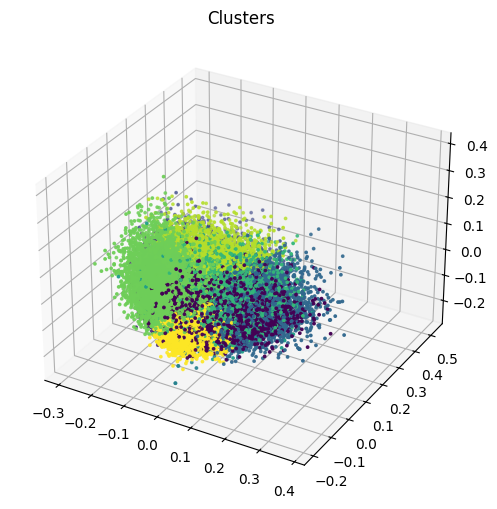

In [7]:
from sklearn.cluster import KMeans
def kmeans_cluster(k, X, verbose=True):
    print(f"KMeans (k={k})")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    kmeans.fit(X)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    inertia = kmeans.inertia_
    sil = None
    
    if k > 1:
        sil = silhouette_score(X, labels)

    if(verbose):
        print("Inertia:", inertia)
        print("Silhouette Score:", sil)

    return labels, centers, inertia, sil, kmeans
# ~5m
labels_km,centers_km,inertia_km,sil_km, kmeans = kmeans_cluster(k,X_transformed)

plot_clusters(X_transformed, labels_km)

In [8]:
show_examples_per_cluster(cleaned_data, labels_km, 3)


Cluster 0
probabl the worst dolph film ever there s noth you d want or expect here don t wast your time dolph play a miser cop with no interest in life hi brother get kill and dolph tri to figur thing out the charact is just plain stupid and stumbl around aimlessli pointless 
---
thi wa the onli time i ever walk out on a movi year later i saw it in the cabl list and thought mayb i should give it anoth tri suffic to say that i wa right the first time thi rank second onli to godzilla as the worst movi i ve ever seen 
---
i manag to sneak away one night and go to the movi theater to see thi one think i wa in for a treat boy wa i wrong consid the talent involv thi ha to be one of the worst movi i ve ever seen everyon in it wa miscast and i find it incred to read on thi site that there are peopl out there who actual li 
---

Cluster 1
zero day lead you to think even re think whi two boy young men would do what they did commit mutual suicid via slaughter their classmat it captur what must b

Através dos dados acima conseguimos ter ideia dos dados agrupados em cada cluster. Os clusters 0, 6 e 7 parecem conter críticas maioritariamente negativas, enquanto que os clusters 3 e 4 já parecem conter críticas mais favoráveis. Alguns clusters, como o 1, 2, 5, 8 e 9, têm críticas negativas e positivas, pelo que não conseguimos perceber qual o tema central destes grupos.

Estes métodos de clustering são não-supervisionados, pelo que não têm em conta as classificações reais das críticas, considerando apenas o texto associado a cada uma.

#### 2.3.2.1 K-Means com PCA


Para percebermos o impacto da remoção de dimensões, vamos aplicar PCA para reduzir o numero de componentes que damos como _input_ ao algoritmo K-Means. O objetivo é perceber se o algoritmo beneficia com menos dimensões ou não. Para isso, temos dois métodos à disposição:

- Método PCA, que atua melhor quando os dados estão escalados (ou centrados), e não é muito recomendado para matrizes esparsas. Este método suporta variancias em percentagens.

- Método TruncatedSVD, que é um método melhor optimizado para matrizes esparsas, e que é mais eficiente em termos de memória. Este método não suporta variancias em percentagens, pelo que temos de aplicar um numero fixo de componentes.

No nosso caso, estamos a trabalhar com matrizes esparsas, pelo que a utilização direta do PCA poderia causar problemas de perfomance. Para usar o PCA, ainda teriamos primeiro de aplicar escalamento (através do StandardSscaler) numa matriz esparsa (com muitos 0's), pelo que o _TruncatedSVD_ acaba por ser a opção mais eficiente para o nosso caso.


In [9]:
def kmeans_cluster_pca(k, X, n_components):
    print(f"KMeans com PCA (k={k}, n_components={n_components})")

    svd = TruncatedSVD(
        n_components=n_components,
        random_state=42
    )

    X_used = svd.fit_transform(X)

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    labels = kmeans.fit_predict(X_used)
    centers = kmeans.cluster_centers_

    inertia = kmeans.inertia_
    sil = None

    if k > 1:
        sil = silhouette_score(X_used, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil, X_used, kmeans



labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,100)
labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,200)
labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,300)

KMeans com PCA (k=10, n_components=100)
Inertia: 6257.71295613676
Silhouette Score: 0.02312592000617362
KMeans com PCA (k=10, n_components=200)
Inertia: 9833.818459762073
Silhouette Score: 0.016342165016215434
KMeans com PCA (k=10, n_components=300)
Inertia: 12599.049285766447
Silhouette Score: 0.010116208187893036


Conseguimos então perceber que, com PCA, os clusters ficam ligeramente melhores (o silhouette score fica mais perto de 0). Ao aumentar o numero de componentes, os clusters começam a ficar menos definidos, e a distancia dos pontos ao centros dos clusters aumenta, talvez porque estamos a dar mais dimensões ao algoritmo de k-means.

Sem PCA, temos os seguintes dados (retirados do _output_ acima):

- Inertia: 41794.0573403712
- Silhouette Score: -0.015088521462772205

Pelo que as melhorias são ligeiramente superiores a não usar PCA. Neste caso, não "compensa" usar PCA, uma vez que não traz melhorias muito significativas.


### 2.3.2 - Clustering com AgglomerativeClustering


Para este método optámos por usar o Complete como parâmetro de linkage, uma vez que permite uma separação mais clara entre os clusters, tendo em conta a maior distância entre os seus elementos. O método Ward não foi utilizado por ser mais pesado em termos de cálculo e demorar mais tempo a convergir.

O método Single, apesar de ser mais rápido, tende a juntar muitos elementos no mesmo cluster, o que resulta num menor número de grupos distintos.


AgglomerativeClustering (k=10)
Silhouette Score: -0.002065373644258619


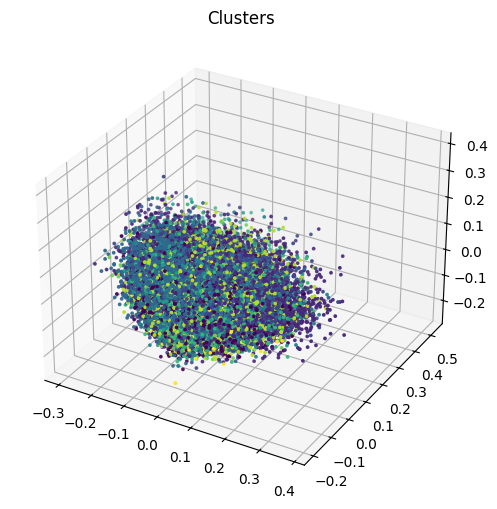

In [ ]:

def agg_cluster(k, X):
    print(f"AgglomerativeClustering (k={k})")
    
    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="complete"        
    )

    a = agg.fit(X)
    labels = a.labels_
    sil = None
    if(k>1):
        sil = silhouette_score(X, labels)
        print("Silhouette Score:", sil)

    return labels, sil

# Sem PCA
# 10k -> 1m30s
# 30k -> 13m14s
# tudo -> 1h
labels_agg,sil_agg = agg_cluster(k,X_dense)
plot_clusters(X_dense, labels_agg)


In [11]:
show_examples_per_cluster(cleaned_data, labels_agg, 3)


Cluster 0
zero day lead you to think even re think whi two boy young men would do what they did commit mutual suicid via slaughter their classmat it captur what must be beyond a bizarr mode of be for two human who have decid to withdraw from common civil in order to defin their own mutual world via coupl dest 
---
the movi wa sub par but thi televis pilot deliv a great springboard into what ha becom a sci fi fan ideal program the actor deliv and the special effect for a televis seri are spectacular have an intellig interest script doesn t hurt either stargat sg is current one of my favorit program 
---
thi movi ha a special way of tell the stori at first i found it rather odd as it jump through time and i had no idea what happen anyway the stori line wa although simpl but still veri real and touch you met someon the first time you fell in love complet but broke up at last and promot a deadli agoni 
---

Cluster 1
word can t describ how bad thi movi is i can t explain it by write onli 

Através dos dados apresentados é possível obter uma perceção geral da forma como as críticas foram agrupadas em cada cluster. Conseguimos observar que os clusters 0, 2, 5, 7 e 8 parecem conter críticas menos favoráveis. Por outro lado, os clusters 1, 3 e 4 aparentam agrupar críticas mais favoráveis.

Em alguns clusters, a distinção não é muito clara, como nos clusters 0 e 9, que incluem críticas positivas e negativas, o que dificulta a identificação do tema central desses grupos.

Este é outro método de clustering que não tem conhecimento das classificações reais das críticas, pelo que reflete sobretudo semelhanças linguísticas e semânticas entre os textos, e não necessariamente uma separação clara entre críticas positivas e negativas.

#### 2.3.2.1 Cluster Hierarquico com PCA


In [12]:
# 300 componentes
svd = TruncatedSVD(
    n_components=300,
    random_state=42
)

X_svd = svd.fit_transform(X_transformed)

# Com PCA
# 10k com SVD -> 17s
# 30k (SVD) -> 2m30s
# tudo (SVD) -> 9m30s
labels_agg,sil_agg = agg_cluster(k,X_svd)

AgglomerativeClustering (k=10)
Silhouette Score: 0.026125354244027205


Neste caso, o PCA, para além de obter melhores resultados, obtem também uma melhor performance. Isto significa que os clusters ficam mais bem definidos com a redução das dimensões, o que faz também com que o algoritmo convirja mais rápido.


### 2.3.3 - Comparação de clusters e impacto do parametro K


Com os resultados acima, conseguimos fazer comparar os clusters que são feitos por ambos os algoritmos. O valor chave que vamos usar é métrica silhouette, visto que o algoritmo k-medias é uma algoritmo baseado em distancias, em que cada ponto é atribuido ao cluster mais perto, e os centróides são recalculados até convergir, e o AgglomerativeClustering é uma algoritmo que não usa centróides, mas que agrupa pontos em clusters e converge quando só existe apenas um único grupo. Por causa dos algoritmos terem modos de funcionamento diferentes, a unica métrica comum entre ambos é a métrica de silhouette, e é essa que vamos analisar.

Em ambos os outputs, o score é sensivelmente perto de 0, que indica que os clusters em ambos os algoritmos estão sobrepostos. As visualizações em 3D acima feitas já demonstram exatamente isso. Outra nota interessante é que usar apenas as dimensões com mais variação (PCA) não traz melhorias significativas em termos de algoritmo, mas faz os algoritmos convergir mais rápido, devido a redução geral dos dados que alimentamos aos algoritmos.

Uma coisa que notámos durante o desenvolvimento é que o AgglomerativeClustering usa muito a memória RAM (ocupando quase 90%) porque como é recursivo, tem que manter em memoria as relações entre os pontos (os agrupamentos), enquanto que o K-Means usa mais CPU, porque tem calcular distancias entre todos os pontos do dataset. Ainda assim, o K-Means converge mais rápido que o hierárquico.

Outra diferença grande entre o AgglomerativeClustering e o K-Means é como lidam com o parâmetro K, uma vez que no K-Means o número de clusters tem de ser definido na chamada, enquanto no clustering hierárquico esse valor pode ser determinado após a construção do dendrograma. Por esse motivo, vamos só analisar o impacto do parametro K no K-Means e interpretar os resultados


range(1, 21, 2)
KMeans (k=1)
KMeans (k=3)
KMeans (k=5)
KMeans (k=7)
KMeans (k=9)
KMeans (k=11)
KMeans (k=13)
KMeans (k=15)
KMeans (k=17)
KMeans (k=19)


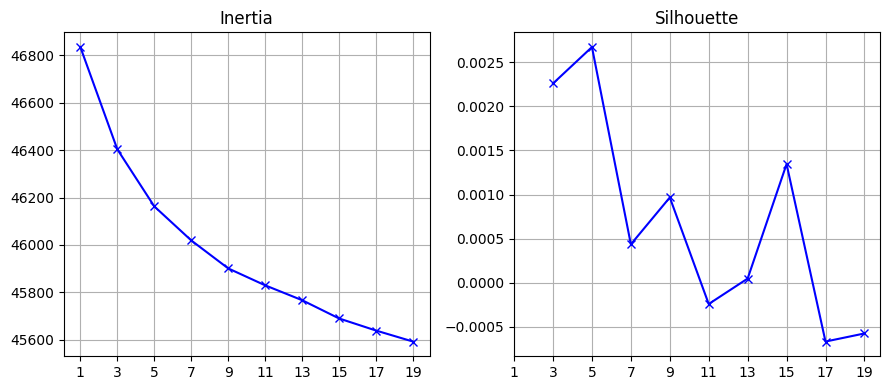

In [13]:
def evaluate_k_values(X, k_list):
    sil_scores = []
    inertia_scores = []
    print(k_list)
    
    for k in k_list:
        labels, centers, inertia, sil, kmeans = kmeans_cluster(k,X, verbose=False)
        sil_scores.append(sil)
        inertia_scores.append(inertia)

    return sil_scores, inertia_scores

k_list = range(1,20+1, 2) 
sil_scores, inertia_scores = evaluate_k_values(X_transformed,k_list)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Inertia plot
axes[0].plot(k_list, inertia_scores, 'bx-')
axes[0].set_title("Inertia")
axes[0].set_xticks(k_list)
axes[0].grid()

# Silhouette plot
axes[1].plot(k_list, sil_scores, 'bx-')
axes[1].set_title("Silhouette")
axes[1].set_xticks(k_list)
axes[1].grid()

plt.tight_layout()
plt.show()


Através dos seguintes dados podemos ver que a métrica de inertia diminui à medida que o valor de K aumenta, isto porque, como temos mais clusters, os pontos de cada cluster ficam mais proximos de cada centróides (ou seja, quanto mais dividirmos os dados, mais próximos dos centros os dados ficam). A métrica de silhouette varia muito dependendo do K, nao sendo claro a tendencia que segue.

No entanto, através dos gráficos acima, conseguimos observar que um bom numero de clusters seria k=15, uma vez que tem uma inertia baixa e uma silhouette alta, o que significa que os pontos ficam próximos dos centróides, e que os clusters ficam mais bem definidos.


# 3 - Conclusões


# 4 - Bibliografia

- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
- https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
- https://www.reddit.com/r/statistics/comments/180nm8y/question_pca_for_visualizing_clusters/
- https://pca4ds.github.io/pca-and-clustering.html
- https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
- https://www.kaggle.com/code/sabanasimbutt/clustering-visualization-of-clusters-using-pca
- https://www.kaggle.com/code/hasanaltunay/agglomerative-clustering-dendrograms-pca
- https://projectai.in/projects/ac30fffa-f885-440c-a9a4-54228fdfebc9/tasks/22ec2a03-6e13-43be-9f45-889382db2d78?tab=task
- https://apxml.com/courses/nlp-fundamentals/chapter-3-nlp-text-classification/hyperparameter-tuning-text-models
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial
- https://stats.stackexchange.com/questions/239481/difference-between-scikit-learn-implementations-of-pca-and-truncatedsvd
